In [ ]:
!pip install -q kagglehub

import kagglehub
import pandas as pd
import numpy as np
import os
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional
import plotly.express as px
import plotly.graph_objects as go
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings("ignore")

print("Downloading dataset...")
path = kagglehub.dataset_download("ashishjangra27/nifty-50-25-yrs-data")
print(f"Dataset downloaded to: {path}")

print("\nContents of the downloaded directory:")
for root, dirs, files in os.walk(path):
    for name in files:
        print(os.path.join(root, name))
    for name in dirs:
        print(os.path.join(root, name))

csv_file_path = os.path.join(path, 'data.csv')
df = pd.read_csv(csv_file_path)

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print("\nDataset loaded successfully. Here are the first 5 rows:")
df.head()

In [ ]:
def create_sliding_window(data, window_size):
    """
    Creates input-output pairs for a supervised learning model.
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

high_prices = df['High'].values

# time windows
time_windows = [30, 60, 90]

# We are storing the generated datasets :
datasets = {}

for window in time_windows:
    X, y = create_sliding_window(high_prices, window)
    datasets[f'X_High_{window}'] = X
    datasets[f'y_High_{window}'] = y
    print(f"Created dataset for window size {window}: X shape {X.shape}, y shape {y.shape}")

In [ ]:
X.shape

In [ ]:
def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

models_to_train = {
    "KNN": KNeighborsRegressor(),
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "BiLSTM": build_bilstm
}

dl_models = ["RNN", "LSTM", "GRU", "BiLSTM"]

In [ ]:
results = []

for window in tqdm(time_windows, desc="Processing Time Windows"):
    # we are getting the data for the current window size
    X_data = datasets[f'X_High_{window}']
    y_data = datasets[f'y_High_{window}']

# Splitting the data into 90% training , 10 % validation data set :
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state=42, shuffle=False)

    for model_name, model_builder in tqdm(models_to_train.items(), desc=f"Training Models for {window}-day window", leave=False):

        print(f"\nTraining {model_name} with {window}-day window...")

        # Model Training
        if model_name in dl_models:
            # Reshape data for DL models: [samples, timesteps, features]
            X_train_dl = np.expand_dims(X_train, -1)
            X_test_dl = np.expand_dims(X_test, -1)

            model = model_builder((X_train_dl.shape[1], 1))
            model.fit(X_train_dl, y_train, epochs=50, batch_size=32, verbose=0)
            y_pred = model.predict(X_test_dl).flatten()
        else: # KNN model
            model = model_builder
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

        # Evaluation
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        print(f"Results for {model_name}_{window}: MAE = {mae:.2f}, RMSE = {rmse:.2f}")

        # Store Results
        results.append({
            "Model": f"{model_name}_{window}",
            "Model_Type": model_name,
            "Window_Size": window,
            "MAE": mae,
            "RMSE": rmse,
            "y_test": y_test, # Storing actuals and predictions for plotting later
            "y_pred": y_pred
        })

results_df = pd.DataFrame(results)

In [20]:
print("Model Performance Summary:")
display(results_df)

Model Performance Summary:


,Model,Model_Type,Window_Size,MAE,RMSE,y_test,y_pred
0,KNN_30,KNN,30,3713.051351,4508.211594,"[18362.3, 18399.45, 18427.95, 18442.15, 18417....","[18061.26, 18011.890000000003, 17923.309999999..."
1,RNN_30,RNN,30,21047.279563,21204.688329,"[18362.3, 18399.45, 18427.95, 18442.15, 18417....","[445.55255, 445.55255, 445.55255, 445.55255, 4..."
2,LSTM_30,LSTM,30,21399.292785,21554.130969,"[18362.3, 18399.45, 18427.95, 18442.15, 18417....","[93.53933, 93.53933, 93.53933, 93.53933, 93.53..."
3,GRU_30,GRU,30,21289.806327,21445.435029,"[18362.3, 18399.45, 18427.95, 18442.15, 18417....","[203.02579, 203.02579, 203.02579, 203.02579, 2..."
4,BiLSTM_30,BiLSTM,30,21246.457816,21402.401732,"[18362.3, 18399.45, 18427.95, 18442.15, 18417....","[246.3743, 246.3743, 246.3743, 246.3743, 246.3..."
5,KNN_60,KNN,60,4104.162700,4873.619961,"[18442.15, 18417.6, 18394.6, 18262.3, 18261.85...","[18317.839999999997, 18200.079999999998, 18200..."
6,RNN_60,RNN,60,21065.587195,21222.523412,"[18442.15, 18417.6, 18394.6, 18262.3, 18261.85...","[442.08325, 442.08325, 442.08325, 442.08325, 4..."
7,LSTM_60,LSTM,60,21370.799720,21525.510836,"[18442.15, 18417.6, 18394.6, 18262.3, 18261.85...","[136.87073, 136.87073, 136.87073, 136.87073, 1..."
8,GRU_60,GRU,60,21315.482886,21470.592603,"[18442.15, 18417.6, 18394.6, 18262.3, 18261.85...","[192.18756, 192.18756, 192.18756, 192.18756, 1..."
9,BiLSTM_60,BiLSTM,60,21255.196921,21410.743383,"[18442.15, 18417.6, 18394.6, 18262.3, 18261.85...","[252.47353, 252.47353, 252.47353, 252.47353, 2..."


In [19]:
best_model_result = results_df.loc[results_df['RMSE'].idxmin()]

print("Best performing model based on RMSE:")
display(best_model_result)

Best performing model based on RMSE:


,0
Model,KNN_30
Model_Type,KNN
Window_Size,30
MAE,3713.051351
RMSE,4508.211594
y_test,"[18362.3, 18399.45, 18427.95, 18442.15, 18417...."
y_pred,"[18061.26, 18011.890000000003, 17923.309999999..."


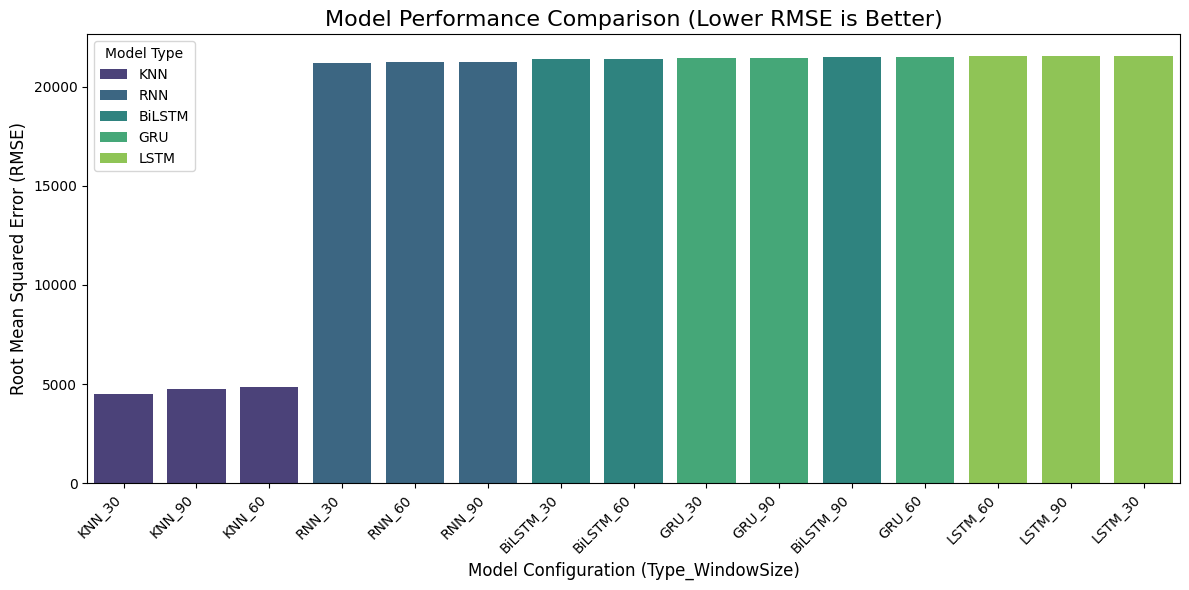

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

results_df_sorted = results_df.sort_values('RMSE', ascending=True)

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', hue='Model_Type', data=results_df_sorted, palette='viridis')
plt.title('Model Performance Comparison (Lower RMSE is Better)', fontsize=16)
plt.xlabel('Model Configuration (Type_WindowSize)', fontsize=12)
plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model Type')
plt.tight_layout()
plt.show()